# Binary Classification of Blurred and Focused Images

## Convolutional Neural Network Based Approach

### Importing the Libraries

In [280]:
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
print("Version:", tf.__version__)
import pandas as pd
from scipy.ndimage import variance
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize

Version: 1.15.0


### Getting the Image Paths

Add the paths to the image folders as shown below

In [281]:
train_path_1_blur = 'CERTH_ImageBlurDataset\\TrainingSet\\Artificially-Blurred\\'
train_path_2_blur = 'CERTH_ImageBlurDataset\\TrainingSet\\Naturally-Blurred\\'
train_path_focused = 'CERTH_ImageBlurDataset\\TrainingSet\\Undistorted\\'
eval_path_1_blur = 'CERTH_ImageBlurDataset\\EvaluationSet\\DigitalBlurSet\\'
eval_path_2_blur = 'CERTH_ImageBlurDataset\\EvaluationSet\\NaturalBlurSet\\'

blur_arti = [f for f in listdir(train_path_1_blur) if isfile(join(train_path_1_blur, f))]
blur_actual = [f for f in listdir(train_path_2_blur) if isfile(join(train_path_2_blur, f))]
focused = [f for f in listdir(train_path_focused) if isfile(join(train_path_focused, f))]
eval_blur_arti = [f for f in listdir(eval_path_1_blur) if isfile(join(eval_path_1_blur, f))]
eval_blur_nat = [f for f in listdir(eval_path_2_blur) if isfile(join(eval_path_2_blur, f))]

train_blur = []
train_focused = []

for i in blur_arti:
    train_blur.append(train_path_1_blur+i)
    
for i in blur_actual:
    train_blur.append(train_path_2_blur+i)

for i in focused:
    train_focused.append(train_path_focused+i)

### Preprocessing Functions

In [284]:
def import_train_dataset(train_blur, train_focused, image_side, batch_size):
    
    '''
        Function that combines the blurred images and focused images to create the training
        dataset. The function first creates a smaller image of size (image_side, image_side, 3)
        and then finds the 2D-DFT on that image. Next the variance of the laplacian of the original
        image is also calulated. Finally the labels are created and then the dataset is shuffled and
        returned.
        
        Args:
            train_blur: Path of all the blurred training images.
            train_focused: Path of all the focused images.
            image_side: Dimension of the smaller image that has to be extracted.
            batch_size: Batch of the images that have to be returned.
            
        Returns:
            images: Contains the smaller image extracted from the original.
            labels: Contains the images.
            var_lap: Contains the variance of the laplacian
            fft: Contains the 2D DFT of the smaller image.   
    '''
    
    n = int(batch_size/2);
    half_side = int(image_side/2)
    path_blur = np.random.randint((np.shape(train_blur)[0]-1), size=(n))
    path_focused = np.random.randint((np.shape(train_focused)[0]-1), size=(n))
    
    images = []
    labels = []
    var_lap = []
    fft = []
    
    for i in path_blur:
        image = cv2.imread(train_blur[i])
        [x,y,_] = np.shape(image)
        var_lap.append([np.var(cv2.Laplacian(image, cv2.CV_64F))])
        image = image[(int(x/2)-half_side):(int(x/2)+half_side), (int(y/2)-half_side):(int(y/2)+half_side), :]
        ftimage = np.fft.fft2(image)
        ftimage = np.fft.fftshift(ftimage)
        fft.append(abs(ftimage))
        images.append(image)
        labels.append([1])
        
    for i in path_focused:
        image = cv2.imread(train_focused[i])
        [x,y,_] = np.shape(image)
        var_lap.append([np.var(cv2.Laplacian(image, cv2.CV_64F))])
        image = image[(int(x/2)-half_side):(int(x/2)+half_side), (int(y/2)-half_side):(int(y/2)+half_side), :]
        ftimage = np.fft.fft2(image)
        ftimage = np.fft.fftshift(ftimage)
        fft.append(abs(ftimage))
        images.append(image)
        labels.append([0])

    images = np.asarray(images, dtype=np.float32)/255
    labels = np.asarray(labels, dtype=np.float32)
    var_lap = np.asarray(var_lap, dtype=np.float32) / 1000
    fft = np.asarray(fft, dtype=np.float32)/10000000
    
    seed = np.random.randint(100)
    np.random.seed(seed)
    np.random.shuffle(images)
    np.random.seed(seed)
    np.random.shuffle(labels)
    np.random.seed(seed)
    np.random.shuffle(var_lap)
    np.random.seed(seed)
    np.random.shuffle(fft)
    
    return images, labels, var_lap, fft

In [283]:
def create_model(image_side):
    
    '''
        Function that creates the CNN and returns the CNN
        
        Args:
            image_side: Contains the dimension of the image that would be trained
        
        Returns:
            model: Contains the CNN.
    '''
    
    
    input_shape = (image_side, image_side, 3)
    input_image = layers.Input(shape = input_shape)
    input_fft = layers.Input(shape = input_shape)
    input_var_lap = layers.Input(shape = (1,))
    
    # image input
    img = layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape)(input_image)
    img = layers.MaxPooling2D((4, 4))(img)
    img = layers.BatchNormalization()(img)
    img = layers.Conv2D(16, (2, 2), activation='relu')(img)
    img = layers.MaxPooling2D((4, 4))(img)
    img = layers.BatchNormalization()(img)
    img = layers.Conv2D(8, (2, 2), activation='relu')(img)
    img = layers.MaxPooling2D((4, 4))(img)
    img = layers.BatchNormalization()(img)
    img = layers.Flatten()(img)
    
    # fft input
    fft = layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape)(input_fft)
    fft = layers.MaxPooling2D((4, 4))(fft)
    fft = layers.BatchNormalization()(fft)
    fft = layers.Conv2D(16, (2, 2), activation='relu')(fft)
    fft = layers.MaxPooling2D((4, 4))(fft)
    fft = layers.BatchNormalization()(fft)
    fft = layers.Conv2D(8, (2, 2), activation='relu')(fft)
    fft = layers.MaxPooling2D((4, 4))(fft)
    fft = layers.BatchNormalization()(fft)
    fft = layers.Flatten()(fft)
    
    # var_lap input
    var_lap = layers.Dense(1, activation='relu', input_shape =(1,))(input_var_lap)
    var_lap = layers.Dense(1, activation='relu')(input_var_lap)
    
    # conmbining the 3 
    combined = layers.Concatenate(axis=1)([img, fft, var_lap])
    combined = layers.Dense(200, activation='relu')(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Dense(100, activation='relu')(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Dense(50, activation='relu')(combined)
    combined = layers.BatchNormalization()(combined)
    combined = layers.Dense(10, activation='relu')(combined)
    out = layers.Dense(1, activation='sigmoid')(combined)
    
    model = models.Model(inputs=[input_image, input_fft, input_var_lap], outputs=[out])
    adam_ = tf.keras.optimizers.Adam(lr = 0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam_, metrics=['accuracy'])
    
    return model

### Defining the CNN

In [286]:
model = create_model(image_side)
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_55 (InputLayer)           [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 399, 399, 32) 416         input_55[0][0]                   
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 399, 399, 32) 416         input_56[0][0]                   
___________________________________________________________________________________________

### Training the CNN

In [288]:
epochs = 30
batch_size = 64
val_batch_size = 64
image_side = 400

loss = []
acc = []
val_loss = []
val_acc = []

for i in range(epochs):
    images, labels, var_lap, fft = import_train_dataset(train_blur, train_focused, image_side, batch_size)
    print('Iteration:', i+1)
    hist = model.fit(x = [images, fft, var_lap], y=labels)
    loss.append(hist.history['loss'])
    acc.append(hist.history['acc'])
    print('_____________________________________________________________________')

Iteration: 1
Train on 64 samples
64/64 [==============================] - 7s 102ms/sample - loss: 0.8380 - acc: 0.4531
_____________________________________________________________________
Iteration: 2
Train on 64 samples
64/64 [==============================] - 5s 77ms/sample - loss: 0.6388 - acc: 0.6250
_____________________________________________________________________
Iteration: 3
Train on 64 samples
64/64 [==============================] - 5s 76ms/sample - loss: 0.7465 - acc: 0.5938
_____________________________________________________________________
Iteration: 4
Train on 64 samples
64/64 [==============================] - 5s 75ms/sample - loss: 0.5866 - acc: 0.6250
_____________________________________________________________________
Iteration: 5
Train on 64 samples
64/64 [==============================] - 5s 76ms/sample - loss: 0.5976 - acc: 0.6406
_____________________________________________________________________
Iteration: 6
Train on 64 samples
64/64 [===================

### Saving the Model

In [289]:
model.save('model_400.hdf5')

### Plotting the Training Graphs

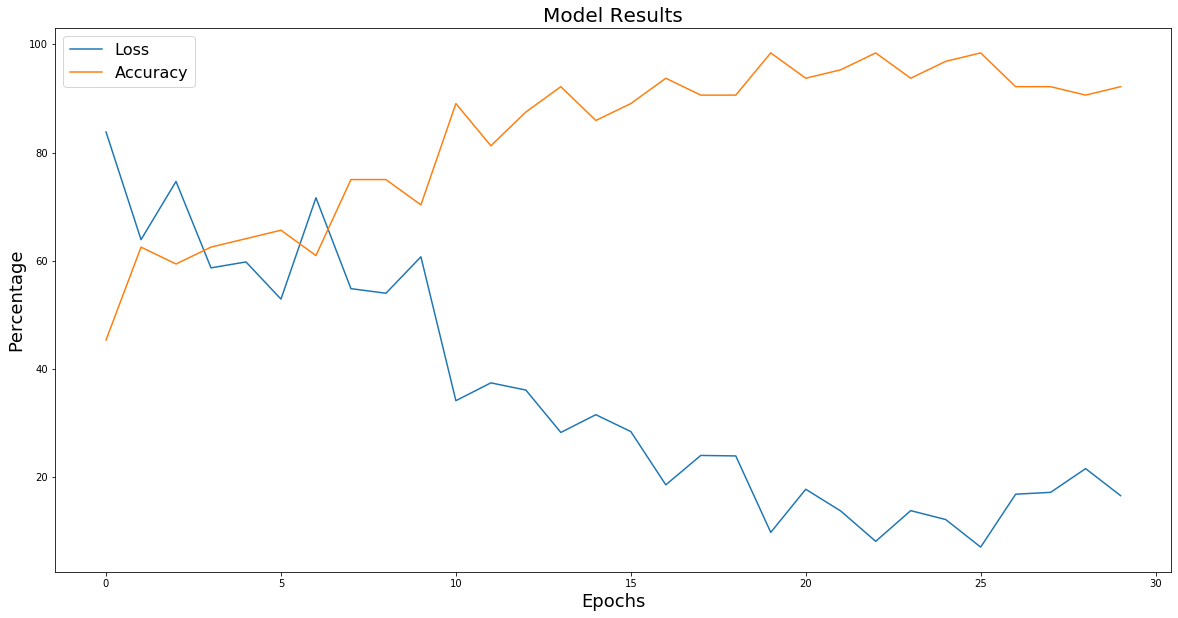

In [299]:
%matplotlib inline

plt.rcParams["figure.figsize"] = (20,10)

plt.plot(range(len(loss)), np.asarray(loss)*100)
plt.plot(np.asarray(acc)*100)
plt.title('Model Results', fontsize= 20)
plt.ylabel('Percentage', fontsize= 18)
plt.xlabel('Epochs', fontsize= 18)
plt.legend(['Loss','Accuracy'], loc='upper left', fontsize = 16)

plt.show()

### Testing the Model on the Evaluation Dataset

In [300]:
df1 = pd.read_excel(r'CERTH_ImageBlurDataset\EvaluationSet\DigitalBlurSet.xlsx')
df2 = pd.read_excel(r'CERTH_ImageBlurDataset\EvaluationSet\NaturalBlurSet.xlsx')
correct = 0
image_size = 400
half_side = int(image_size/2)

total += df1['Image Name'].size

for i in range(df1['Image Name'].size):
    
    images = []
    labels = []
    var_lap = []
    fft = []
    
    image = cv2.imread(eval_path_1_blur + df1['Image Name'][i])
    [x,y,_] = np.shape(image)
    var_lap.append([np.var(cv2.Laplacian(image, cv2.CV_64F))])
    image = image[(int(x/2)-half_side):(int(x/2)+half_side), (int(y/2)-half_side):(int(y/2)+half_side), :]
    ftimage = np.fft.fft2(image)
    ftimage = np.fft.fftshift(ftimage)
    fft.append(abs(ftimage))
    images.append(image)
    
    images = np.asarray(images, dtype=np.float32)/255
    var_lap = np.asarray(var_lap, dtype=np.float32) / 1000
    fft = np.asarray(fft, dtype=np.float32)/10000000
    
    x = model.predict(x = [images, fft, var_lap])
    if ((x[0][0]>0.5 and df1['Blur Label'][i]==1) or (x[0][0]<0.5 and df1['Blur Label'][i]==-1)):
        
        correct = correct + 1

total += df2['Image Name'].size

for i in range(df2['Image Name'].size):
    
    images = []
    labels = []
    var_lap = []
    fft = []
    
    image = cv2.imread(eval_path_2_blur + df2['Image Name'][i] + '.jpg')
    [x,y,_] = np.shape(image)
    var_lap.append([np.var(cv2.Laplacian(image, cv2.CV_64F))])
    image = image[(int(x/2)-half_side):(int(x/2)+half_side), (int(y/2)-half_side):(int(y/2)+half_side), :]
    ftimage = np.fft.fft2(image)
    ftimage = np.fft.fftshift(ftimage)
    fft.append(abs(ftimage))
    images.append(image)
    
    images = np.asarray(images, dtype=np.float32)/255
    var_lap = np.asarray(var_lap, dtype=np.float32) / 1000
    fft = np.asarray(fft, dtype=np.float32)/10000000
    
    x = model.predict(x = [images, fft, var_lap])
    if ((x[0][0]>0.5 and df2['Blur Label'][i]==1) or (x[0][0]<0.5 and df2['Blur Label'][i]==-1)):
        
        correct = correct + 1

### Accuracy

In [306]:
print(f'The accuracy of the CNN on the Evaluation set is: {correct/total*100} %')

The accuracy of the CNN on the Evaluation set is: 16.292382210479964 %


## Support Vector Machine Based Approach

### Importing the Libraries

In [308]:
from scipy.ndimage import variance
from skimage import io
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score

### Creating the Training Dataset

In [309]:
training_data = [] 
labels = []

for i in train_blur:
    img = io.imread(i)
    img = rgb2gray(img)
    edge_laplace = laplace(img, ksize=3)
    training_data.append([variance(edge_laplace), np.amax(edge_laplace)])
    labels.append(1)

for i in train_focused:
    img = io.imread(i)
    img = rgb2gray(img)
    edge_laplace = laplace(img, ksize=3)
    training_data.append([variance(edge_laplace), np.amax(edge_laplace)])
    labels.append(0)

### Creating the Test Dataset

In [310]:
test_data = []
test_labels = []

for i in range(df1['Image Name'].size):
    
    img = io.imread(eval_path_1_blur + df1['Image Name'][i])
    img = rgb2gray(img)
    edge_laplace = laplace(img, ksize=3)
    test_data.append([variance(edge_laplace), np.amax(edge_laplace)])
    test_labels.append(max(0, df1['Blur Label'][i]))

for i in range(df2['Image Name'].size):
    
    img = io.imread(eval_path_2_blur + df2['Image Name'][i] + '.jpg')
    img = rgb2gray(img)
    edge_laplace = laplace(img, ksize=3)
    test_data.append([variance(edge_laplace), np.amax(edge_laplace)])
    test_labels.append(max(0, df2['Blur Label'][i]))

### Training the SVM

In [312]:
# train the classifier (support vector machine)
train_data =  preprocessing.scale(training_data)
clf = svm.SVC(C=1)
clf.fit(train_data,labels)

SVC(C=1)

### Accuracy of the Model on the Training Dataset 

In [315]:
print(f'The accuracy of the SVM on the training set is: {accuracy_score(labels, clf.predict(train_data))*100} %')

The accuracy of the SVM on the training set is: 79.39698492462311 %


### Accuracy of the Model on the Evaluation Dataset

In [318]:
test_data =  preprocessing.scale(test_data)
print(f'The accuracy of the SVM on the evaluation set is: {accuracy_score(test_labels, clf.predict(test_data))*100} %')

The accuracy of the SVM on the evaluation set is: 70.87837837837839 %
